In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LogNorm
from pandas.plotting import table
from sklearn.metrics import confusion_matrix
from utils.unification import unify_speciesnet_results, unify_deepfaune_results

#### Single

Setup

In [59]:
MODEL_NAME = 'deepfaune'
path = 'results/deepfaune/results_deepfaune_2025_11_27_12_51.csv'
unify_results = unify_deepfaune_results  # function or None

if path.split('/')[1] != MODEL_NAME:
    raise ValueError()

Calculate statistics

In [60]:
results = pd.read_csv(path, index_col=0)
if results.iloc[0][0].split('/')[1] != '..':
    results.image = '../' + results.image
if unify_results is not None:
    results = unify_results(results)
og = pd.read_csv('y_clean_thin.csv')
og = og[['image_path', 'species']]
og.image_path = '../' + og.image_path
merged = results.merge(og, left_on='image', right_on='image_path')
if merged.empty:
    raise ValueError()

# non empty
merged['model_correct'] = merged.detected_animal == merged.species
merged_no_empty = merged[~((merged.detected_animal == 'empty') & (merged.species != 'empty'))]

# accuracies
N = len(merged_no_empty)
n_model_correct = np.sum(merged_no_empty.model_correct)
overall_accuracy = 100 * n_model_correct / N

# Counts of incorrectly labeled species:
# display(merged_no_empty[~merged_no_empty.model_correct].species.value_counts())

/tmp/ipykernel_14449/945765136.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if results.iloc[0][0].split('/')[1] != '..':


Accuracies

In [61]:
accuracy_per_species = (
    merged_no_empty.groupby('species')
    .agg(
        accuracy=('model_correct', 'mean'),  # mean(True/False)
        count=('model_correct', 'size')
    )
    .sort_values('accuracy', ascending=False)
)

accuracy_per_species.accuracy = \
    (accuracy_per_species.accuracy * 100).round(1)
accuracy_per_species.rename(columns={'accuracy': 'Accuracy [%]'}, inplace=True)
accuracy_per_species['count'] = accuracy_per_species['count'].astype(str)

# ---- Create figure ----
fig, ax = plt.subplots(figsize=(4, 0.2))
fig.suptitle(
    f"{MODEL_NAME.title()} overall accuracy: {overall_accuracy:.2f}%",
    fontsize=12, y=1.5, x=0.39
)
ax.axis('off')
tbl = table(ax, accuracy_per_species, colWidths=[.33, .2])
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)

plt.savefig(f'{path[:-4]}_AT.jpg', dpi=300, bbox_inches='tight')
plt.close()

img = Image.open(f'{path[:-4]}_AT.jpg')  # heck it
cropped = img.crop((0, 0, 1150, 1543))
cropped.save(f'{path[:-4]}_AT.jpg')
accuracy_per_species.to_csv(f'{path[:-4]}_ACC_DF.csv')

Confusion matrix

In [62]:
# Create confusion matrix
labels = sorted(merged_no_empty['species'].unique())  # consistent ordering
cm = confusion_matrix(merged_no_empty['species'], merged_no_empty['detected_animal'], labels=labels)

# Plot
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels,
            norm=LogNorm(vmin=1, vmax=cm.max()))
plt.xlabel("Predicted species")
plt.ylabel("True species")
plt.title(f"Confusion Matrix {MODEL_NAME}")
plt.tight_layout()

plt.savefig(f'{path[:-4]}_CM.jpg', dpi=200, bbox_inches='tight')
plt.close()

#### Combined

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

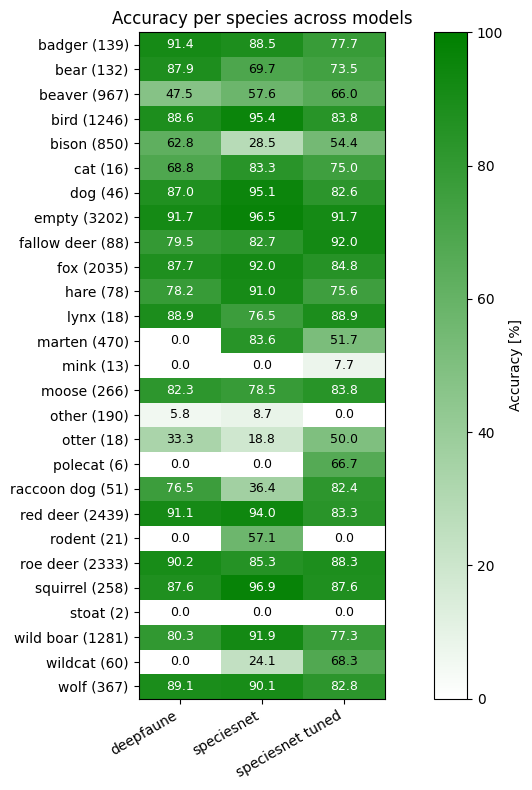

In [57]:
deepfaune = pd.read_csv('results/deepfaune/results_deepfaune_2025_11_22_17_51_ACC_DF.csv')
# deepfaune_head = pd.read_csv('', index_col=0)
speciesnet = pd.read_csv('results/speciesnet/results_speciesnet_2025_11_22_11_21_ACC_DF.csv')
speciesnet_head = pd.read_csv('results/speciesnet_head/results_square_speciesnet_head_2_2025_11_26_10_04_ACC_DF.csv')

dfs = [deepfaune, speciesnet, speciesnet_head]
animals = sorted(list(deepfaune["species"]))
animals_and_counts = [f"{name} ({deepfaune[deepfaune.species==name].iloc[0,2]})" for name in animals]

# Build matrix rows=animals, cols=dataframes
matrix = np.zeros((len(animals), len(dfs)))

for col, df in enumerate(dfs):
    for _, row in df.iterrows():
        matrix[animals.index(row["species"]), col] = row["Accuracy [%]"]

# Create colormap from white to light green
cmap = LinearSegmentedColormap.from_list("white_to_green", ["white", "green"])

plt.figure(figsize=(10, 8))
plt.imshow(matrix, cmap=cmap, vmin=0, vmax=100, aspect=0.3)
plt.colorbar(label="Accuracy [%]")

plt.xticks(range(len(dfs)), ['deepfaune', 'speciesnet', 'speciesnet tuned'], rotation=30, ha='right')
plt.yticks(range(len(animals)), animals_and_counts)

# Add values
for i in range(len(animals)):
    for j in range(len(dfs)):
        value = matrix[i, j]
        plt.text(j, i, f"{value:.1f}", ha='center', va='center',
                 color="black" if value < 70 else "white", fontsize=9)

plt.title("Accuracy per species across models")
plt.tight_layout()
plt.show()

In [56]:
animals

['badger (139)',
 'bear (132)',
 'beaver (967)',
 'bird (1246)',
 'bison (850)',
 'cat (16)',
 'dog (46)',
 'empty (3202)',
 'fallow deer (88)',
 'fox (2035)',
 'hare (78)',
 'lynx (18)',
 'marten (470)',
 'mink (13)',
 'moose (266)',
 'other (190)',
 'otter (18)',
 'polecat (6)',
 'raccoon dog (51)',
 'red deer (2439)',
 'rodent (21)',
 'roe deer (2333)',
 'squirrel (258)',
 'stoat (2)',
 'wild boar (1281)',
 'wildcat (60)',
 'wolf (367)']